# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [38]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [3]:
##### Change this cell to suit your file structure #####
MAZURKAS_ROOT = Path('/data/Datasets/Chopin_Mazurkas') # Path to Mazurkas dataset root directory
OUT_ROOT = Path().absolute() # Output root directory (this is where features, paths, etc. will be saved)
########################################################

In [4]:
ANNOTATIONS_ROOT = MAZURKAS_ROOT / 'annotations_beat'
query_list = Path('cfg_files/query.test.list')
query_list_train = Path('cfg_files/query.train.list')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [ ]:
def eval_dir(hypdir, querylist, hop_sec, savefile = None):
    '''
    Find errors for all alignment paths in a given directory
    '''
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir / (basename + '.pkl')
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        os.makedirs(os.path.split(savefile)[0], exist_ok = True)
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [ ]:
def eval_file(hypfile, hop_sec):
    '''
    Find errors in a given file
    '''
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (ANNOTATIONS_ROOT / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (ANNOTATIONS_ROOT / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [ ]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [ ]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [ ]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate a single hypothesis directory.

In [ ]:
hypdir = OUT_ROOT / 'experiments_test/clean/WSDTW_2'
savefile = OUT_ROOT / 'evaluations_test/clean/WSDTW_2_clean'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

In [ ]:
hypdir = OUT_ROOT / 'experiments_test/clean/SSDTW_8'
savefile = OUT_ROOT / 'evaluations_test/clean/SSDTW_8.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Evaluate all hypothesis directories.

In [ ]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    '''
    Find errors for all alignments in all subdirectories of rootdir
    '''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for hypdir in glob.glob(f'{str(rootdir)}/*'):
        hypdirPath = Path(hypdir)
        savefile = outdir / (os.path.basename(hypdir) + '.pkl')
        allErrs = eval_dir(hypdirPath, querylist, hop_sec, savefile = savefile)

In [ ]:
EXPERIMENTS_ROOT = OUT_ROOT / 'experiments_test/clean'
hop_sec = 512 * 1 / 22050
outdir = OUT_ROOT / 'evaluations_test/clean'
eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

### Plot error vs tolerance

In [ ]:
def calc_error_rates(errFile, maxTol):
    '''
    Calculate the error rates at various error tolerances for a single error file
    '''
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [ ]:
def calc_error_rates_batch(indir, basenames, maxTol):
    '''
    Calculate the error rates at various error tolerances for all error files
    '''
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir / (basename + '.pkl')
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [ ]:
def plot_multiple_roc(errRates, basenames):
    '''
    Plot error tolerance vs error rate for multiple systems as lines
    '''
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [ ]:
EVAL_ROOT_DIR = OUT_ROOT / 'evaluations_test/clean'

toPlot = ['DTW', 'FastDTW',
          'NSDTW_2', 'NSDTW_4', 'NSDTW_8', 'NSDTW_16', 'NSDTW_32', \
          'WSDTW_2', 'WSDTW_4', 'WSDTW_8', 'WSDTW_16', 'WSDTW_32', \
          'SSDTW_2', 'SSDTW_4', 'SSDTW_8', 'SSDTW_16', 'SSDTW_32']

maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

In [ ]:
plot_multiple_roc(errRates, toPlot)

### Histogram of selected error rates

In [ ]:
def plot_grouped_histogram1(errRates_bars, SSDTW_errRates, NSDTW_errRates, basenames, tols, savefile = None):
    '''
    Create final plot of error rates of each system at multiple error tolerances
    '''
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates_bars[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot (DTW & WSDTW)
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate (%)", size=14)
    plt.legend(loc='upper right')
    
    
    # overlay dots for SSDTW results
    if errRates_bars.shape[0] == 7:
        width_bar = .116
    else:
        width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(SSDTW_errRates.shape[0]):
            if errRates_bars.shape[0] == 7:
                x_coords.append(i+(-1+j)*width_bar)
            else:
                x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(SSDTW_errRates[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'ko', markersize=3)
    
    # overlay dots for NSDTW results
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(NSDTW_errRates.shape[0]):
            if errRates_bars.shape[0] == 7:
                x_coords.append(i+(-1+j)*width_bar)
            else:
                x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(NSDTW_errRates[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'rx', markersize=3)
    
    if savefile:
        plt.savefig(savefile, bbox_inches = 'tight')
    
    return

In [ ]:
tols = [10, 20, 50, 100, 200, 500] # in msec
display_names = ['DTW', 'FastDTW', 'WSDTW-2', 'WSDTW-4', 'WSDTW-8', 'WSDTW-16','WSDTW-32']
savefile = OUT_ROOT / 'results.png'
barRates = np.zeros((7, errRates.shape[1]))
barRates[0:2,:] = errRates[0:2,:]
barRates[2:, :] = errRates[7:12,:]
NSDTW_errRates = errRates[2:7,:]
SSDTW_errRates = errRates[12:,:]
plot_grouped_histogram1(barRates, SSDTW_errRates, NSDTW_errRates, display_names, tols, savefile)

## Noisy Data Plot

In [ ]:
SNR_Vals = [20, 15, 10, 5, 0, -5, -10]

In [ ]:
for SNR in SNR_Vals:
    EXPERIMENTS_ROOT = OUT_ROOT / ('experiments_test/noisy_%sdB' % str(SNR))
    hop_sec = 512 * 1 / 22050
    outdir = OUT_ROOT / ('evaluations_test/noisy_%sdB' % str(SNR))
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

In [ ]:
toPlot = ["DTW", "FastDTW", "WSDTW_2", "WSDTW_4", "WSDTW_8", "WSDTW_16", "WSDTW_32"]

errRates100 = np.zeros((7, len(toPlot))) # Each row is a different SNR, each col is a different system
errRates20 = np.zeros((7, len(toPlot)))
errRates500 = np.zeros((7, len(toPlot)))

for i, SNR in enumerate(SNR_Vals):
    EVAL_ROOT_DIR = OUT_ROOT / ('evaluations_test/noisy_%sdB' % str(SNR))
    
    maxTol = 1000 # in msec
    theseErrRates, _ = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)
    for j in range(len(toPlot)):
        errRates100[i, j] = theseErrRates[j, 100]
        errRates20[i, j] = theseErrRates[j, 20]
        errRates500[i, j] = theseErrRates[j, 500]

In [ ]:
x_coords = []
y_coords20 = []
y_coords500 = []
for i in range(len(toPlot)):
    width = 0.12
    plt.bar(np.arange(7)+i * width, errRates100[:,i] * 100, width);

    plt.ylim([0,100]);
    plt.ylabel("Error Rate (%)")
    
    plt.xlabel("SNR (dB)")
    plt.xticks(np.arange(7) + 3 * width, SNR_Vals);
    
    x_coords.append(np.arange(7) + (i - 0.1) * width)
    y_coords20.append(errRates20[:,i] * 100)
    y_coords500.append(errRates500[:,i] * 100)

labels = ["DTW", "FastDTW", "WSDTW-2", "WSDTW-4", "WSDTW-8", "WSDTW-16", "WSDTW-32"]
plt.legend(labels, loc = (1.05,0.55));

plt.plot(x_coords, y_coords20, 'k_', markersize=4);
plt.plot(x_coords, y_coords500, 'k_', markersize=4);

plt.savefig(OUT_ROOT / "SNR_results.png", bbox_inches = 'tight')

### Runtime Analysis

In [40]:
dtw_runtimes, dtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/dtw_prof.pkl', 'rb'))
pardtw_runtimes, pardtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/pardtw_prof.pkl', 'rb'))
fastdtw_runtimes, fastdtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/fastdtw_prof.pkl', 'rb'))
nsdtw_runtimes, nsdtw_segments, nsdtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/nsdtw_prof.pkl', 'rb'))
wsdtw_runtimes, wsdtw_segments, wsdtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/wsdtw_prof.pkl', 'rb'))
ssdtw_runtimes, ssdtw_segments, ssdtw_sizes = pickle.load(open(OUT_ROOT / 'profiles/ssdtw_prof.pkl', 'rb'))

Numbers for runtime table

In [41]:
dtw_avgs = np.mean(np.sum(dtw_runtimes[::-1,:,:], axis=2), axis=1)

In [42]:
pardtw_avgs = np.mean(np.sum(pardtw_runtimes[::-1,:,:], axis=2), axis=1)

In [43]:
fastdtw_avgs = np.mean(fastdtw_runtimes[::-1,:], axis=1)

In [44]:
nsdtw_avgs = np.mean(np.sum(nsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [45]:
wsdtw_avgs = np.mean(np.sum(wsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [46]:
ssdtw_avgs = np.mean(np.sum(ssdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [47]:
all_avgs = np.vstack((dtw_avgs.reshape((1,-1)), (pardtw_avgs.reshape((1,-1))), fastdtw_avgs, \
                     nsdtw_avgs, wsdtw_avgs, ssdtw_avgs))

Make Runtime Table

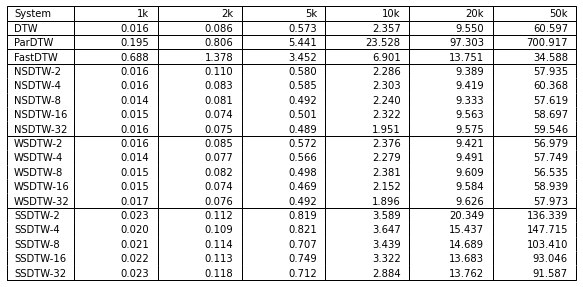

In [35]:
columns = ['1k', '2k', '5k', '10k', '20k', '50k']
rows = ["System",'DTW', 'ParDTW', 'FastDTW']
segment_algs = ['NSDTW', 'WSDTW', 'SSDTW']
num_segs = [2, 4, 8, 16, 32]
for alg_name in segment_algs:
    for num_seg in num_segs:
        rows.append(alg_name + '-' + str(num_seg))
        
cell_text = [columns]
for i in range(len(rows) - 1):
    cell_text.append(['%1.3f' % x for x in all_avgs[i,:]])
        

plt.axis('off')

tab = plt.table(cellText=cell_text, rowLabels=rows, loc='center')

for key, cell in tab.get_celld().items():
    if key[0] in [0,1,2,3,4,9,14]: #[0,1,2,7,12]:
        cell.visible_edges = "TRL"
    elif key[0] == 18:
        cell.visible_edges = "BRL"
    else:
        cell.visible_edges = "RL"

tab.scale(1.5, 1.2);


plt.savefig(OUT_ROOT / 'runtime_table.png',
            bbox_inches='tight',
            dpi=150
            )

plt.show()

Breakdown of runtime by component

In [48]:
# get DTW percent of total runtime by component
dtw_avgs = np.mean(dtw_runtimes, axis=1)
dtw_avgs = dtw_avgs / np.sum(dtw_avgs, axis=1, keepdims=True) * 100.0
dtw_avgs = dtw_avgs[::-1,:]
dtw_avgs = np.hstack((dtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
dtw_df = pd.DataFrame(dtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=dtw_sizes[::-1])

In [51]:
np.mean(dtw_runtimes, axis=1)

array([[1.20236669e+01, 4.85607096e+01, 1.30088568e-02],
       [2.00321600e+00, 7.54321966e+00, 3.90474796e-03],
       [4.79434752e-01, 1.84516020e+00, 3.22255135e-02],
       [1.11656618e-01, 4.60662317e-01, 7.01761246e-04],
       [1.82390928e-02, 6.78628206e-02, 2.65669823e-04],
       [2.28569508e-03, 1.34491444e-02, 1.16181374e-04]])

In [ ]:
# get NSDTW percent of total runtime by component
nsdtw_avgs = np.mean(nsdtw_runtimes, axis=2)
nsdtw_avgs = nsdtw_avgs / np.sum(nsdtw_avgs, axis=2, keepdims=True) * 100.0
nsdtw_avgs = nsdtw_avgs[4,::-1,:] # focus on K=32 segments
nsdtw_avgs = np.hstack((nsdtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
nsdtw_df = pd.DataFrame(nsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=nsdtw_sizes[::-1])

In [ ]:
# get WSDTW percent of total runtime by component
wsdtw_avgs = np.mean(wsdtw_runtimes, axis=2)
wsdtw_avgs = wsdtw_avgs / np.sum(wsdtw_avgs, axis=2, keepdims=True) * 100.0
wsdtw_avgs = wsdtw_avgs[4,::-1,:] # focus on K=32 segments
wsdtw_avgs = wsdtw_avgs[:,[0,1,4,2,3]] # original order: cost, frm dp, seg dp, seg back, frm back
wsdtw_df = pd.DataFrame(wsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=wsdtw_sizes[::-1])

In [ ]:
# get SSDTW percent of total runtime by component
ssdtw_avgs = np.mean(ssdtw_runtimes, axis=2)
ssdtw_avgs = ssdtw_avgs / np.sum(ssdtw_avgs, axis=2, keepdims=True) * 100.0
ssdtw_avgs = ssdtw_avgs[4,::-1,:] # focus on K=32 segments
#print(ssdtw_avgs)
ssdtw_avgs[:,2] = ssdtw_avgs[:,2] + ssdtw_avgs[:,5] # combine runtimes from both frame-level backtracking stages
ssdtw_avgs = ssdtw_avgs[:,0:5] # order: cost, frm dp, frm back, seg dp, seg back
ssdtw_df = pd.DataFrame(ssdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=ssdtw_sizes[::-1])

Make Plot for Breakdown of Runtime

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4)

# DTW plot
ax = dtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[0])
ax.set_title("DTW")
ax.set_ylabel("% Total Runtime", size=13),
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# NSDTW plot
ax = nsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[1])
ax.set_title("NSDTW-32")
ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# WSDTW plot
ax = wsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[2])
ax.set_title("WSDTW-32")
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# SSDTW plot
ax = ssdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[3])
ax.set_title("SSDTW-32")
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)

ax.legend(bbox_to_anchor=(1, 1))


plt.savefig(OUT_ROOT / 'runtime_plot.png',
            bbox_inches='tight',
            dpi=150
            )

plt.show()

### Data Stats for paper

Collecting some stats on the audio data

In [ ]:
root_dir = MAZURKAS_ROOT / 'wav_22050_mono'

In [ ]:
def printAudioStats(indir):
    durs = []
    for infile in glob.glob(f'{indir}/*.wav'):
        y, sr = lb.load(infile)
        durs.append(len(y)/sr)
    durs = np.array(durs)
    
    print(os.path.basename(indir))
    print('---------')
    print(f'Min: {np.min(durs)} s')
    print(f'Max: {np.max(durs)} s')
    print(f'Mean: {np.mean(durs)} s')
    print(f'Std: {np.std(durs)} s')

In [ ]:
for indir in glob.glob(f'{str(root_dir)}/*'):
    printAudioStats(indir)